# Capital Evictions
Impact of development on eviction rates in Washington D.C.


## Table of Contents
1. <a href ='#goal'>Problem Statement</a>
2. <a href='#datasources'>Data Sources</a>
3. <a href='#EDA'>Exploratory Data Analysis</a>
4. <a href='#regression'>Regression</a>
5. <a href='#findings'>Analysis and Findings</a>
6. <a href='#recs'>Recommendations</a>

In [37]:
# Import libraries and set defaults
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

<a id='goal'></a>
## Problem Statement

The goal of this analysis is to gain a better understanding of the relationship between Planned Unit Developments (PUDs), demographic factors, and eviction rates.

<a id='datasources'></a>
## Data Sources

**The Eviction Lab** (https://data-downloads.evictionlab.org/)

A research institution of Princeton University, The Eviction Lab is led by Matthew Desmond with the goal of creating a national resource for tracking evictions and eviction filings.

This project utilizes 2016 evictions data for census block groups within Washington D.C.
 
<br>

**Open Data DC** (https://opendata.dc.gov/datasets/1b3e77aaa6154d1285af639323b0504f_14/data)

A Planned Unit Development refers to a requested exemption from D.C. zoning regulations.  In exchange for the exemption, the developers must offer a community benefit within the local area.  Examples of community benefits include the provision of affordable housing, creation of a park, or contribution to a non-profit. 

This project joins PUD records from Open Data DC with additional research conducted by third-party advocacy group Grassroots D.C. (http://www.grassrootsdc.org/)


In [134]:
# import data
puds = pd.read_csv('data/final_datasets/master_puds_blocks.csv')

<a id='EDA'></a>
## Exploratory Data Analysis

In [3]:
%run python_files/data_viz

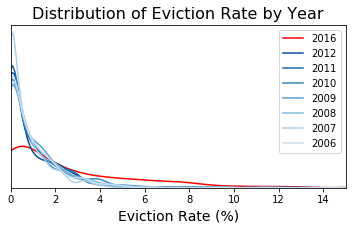

In [4]:
years_dist()

The distribution of eviction rates for 2016 differs significantly from other years in the dataset. However, The Eviction Lab utilizes 2016 as their baseline year for comparison across geographies. Based on their data collection methodology, more records may have been collected for 2016 relative to other years.

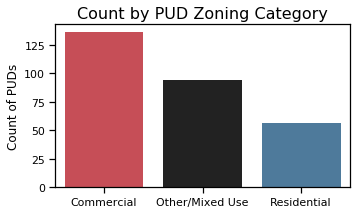

In [5]:
pud_count_by_type(5.3,3)

Majority of PUDs are commercial, followed by mixed use zoning.

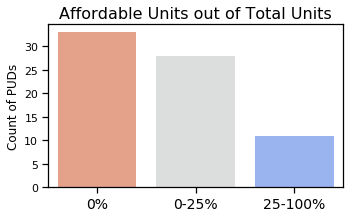

In [6]:
affordable_units_count(5.3,3)

In general, residential PUDs do not include provision of affordable units.

<a id='regression'></a>
## Regression

In [151]:
%run python_files/regression

#### Remove Outliers

In [8]:
puds_to_transform = shrink_data(puds) # limit data to continuous variables
X, y = drop_outliers(puds_to_transform) # drop rows containing a z-score greater than 3
print('Rows in original dataset:', puds_to_transform.shape[0])
print('Rows in updated dataset:', X.shape[0])

Rows in original dataset: 599
Rows in updated dataset: 481


#### Multicolinearity Check

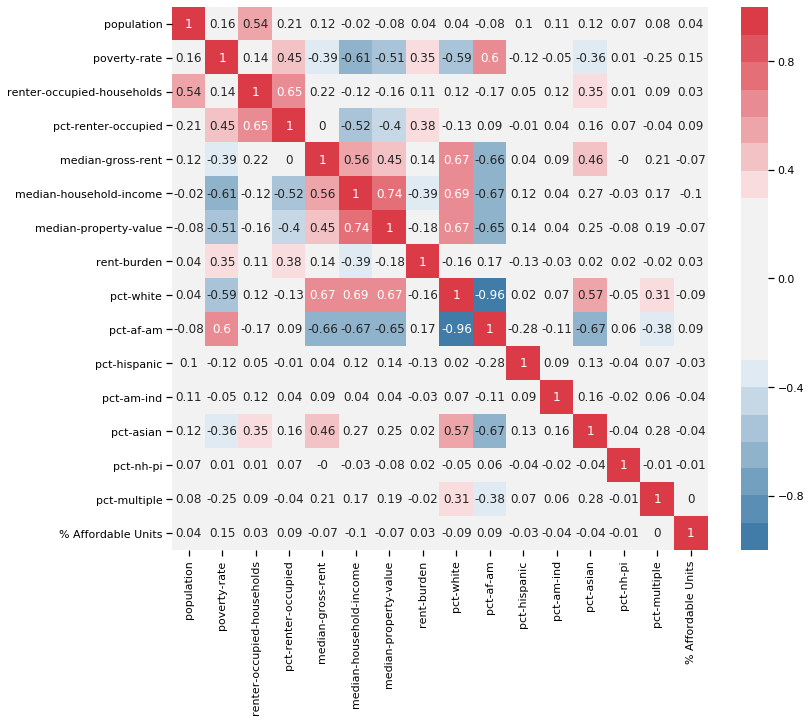

In [9]:
multicolinearity_check(X)

The only variables with a correlation score > 0.75 are 'pct-af-am' and 'pct-white'. Otherwise, multicolinearity is not a significant issue with this dataset.

In [10]:
X = X.drop('pct-af-am',axis=1)

#### Test Train Split

In [11]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=12)

In [12]:
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train.transform(lambda x: np.log(x + 1)))
X_test = ms.transform(X_test.transform(lambda x: np.log(x + 1)))

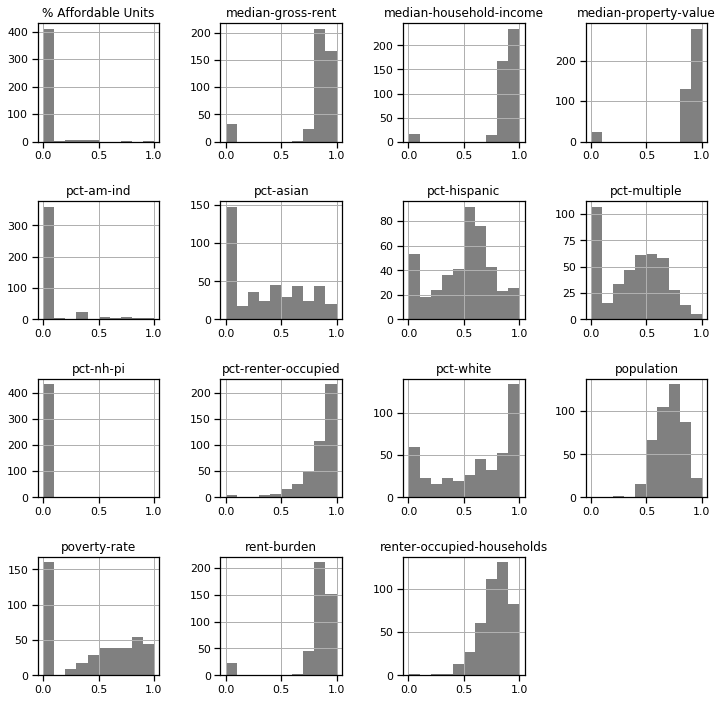

In [13]:
X_labels = [el for el in X.columns]
X, y = transform_arrays_to_df(X_train, y_train, X_labels)
feature_histogram(X)

### Multiple Linear Regression

In [14]:
# add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [15]:
# multiple linear regression on training data
X_labels = [el for el in X.columns]
model, result = lin_reg(X_train,y_train)
create_summary(result, X_labels)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          eviction-rate   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     40.44
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           1.36e-71
Time:                        16:23:24   Log-Likelihood:                -877.52
No. Observations:                 432   AIC:                             1787.
Df Residuals:                     416   BIC:                             1852.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                      0.6920      0.882      0.784      0.433      -1.042       2.426
population                     1.4615      0.909      1.608      0.109      -0.325       3.249
poverty-rate                   1.6598      0.346      4.801      0.000       0.980       2.339
renter-occupied-households     0.0882      1.411      0.063      0.950      -2.685       2.861
pct-renter-occupied            3.2745      1.225      2.674      0.008       0.867       5.682
median-gross-rent             -1.0000      0.612     -1.633      0.103      -2.204       0.204
median-household-income        0.9026      0.594      1.521      0.129      -0.264       2.069
median-property-value          0.2189      0.495      0.442      0.658      -0.754       1.191
rent-burden                    0.4059      0.746      0.544      0.586      -1.060       1.872
pct-white                     -4.8604      0.475    -10.234      0.000      -5.794      -3.927
pct-hispanic                  -0.8521      0.388     -2.196      0.029      -1.615      -0.089
pct-am-ind                     0.0680      0.426      0.160      0.873      -0.770       0.906
pct-asian                     -0.1438      0.422     -0.341      0.734      -0.974       0.686
pct-nh-pi                     -0.1546      1.935     -0.080      0.936      -3.958       3.649
pct-multiple                   0.8346      0.378      2.209      0.028       0.092       1.577
% Affordable Units            -0.5521      0.902     -0.612      0.541      -2.324       1.220
==============================================================================
Omnibus:                       42.402   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.374
Skew:                           0.606   Prob(JB):                     4.29e-17
Kurtosis:                       4.649   Cond. No.                         56.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

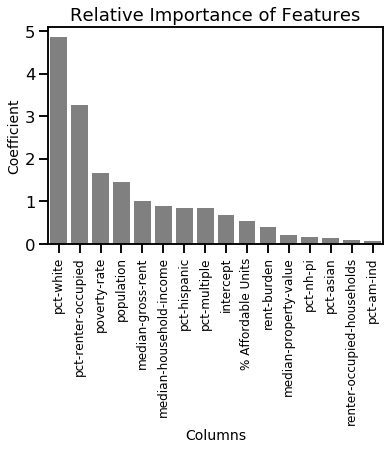

In [16]:
feature_bar_chart(result, X_labels)

Based on coeffients of scaled features, the most important variables for predicting eviction rates at the block group level are “pct-white”, "pct-renter-occupied," “poverty-rate.”

### Residuals Analysis

In [17]:
y_hat_train = result.predict()

In [18]:
training_table = create_values_table(X, 'pct-white', y, y_hat_train)
training_table.head()

,pct-white,y,y_hat,residual
0,0.694088,4.90,3.642673,1.257327
1,0.498752,3.22,3.964500,-0.744500
2,0.938604,0.00,0.483198,-0.483198
3,0.502467,0.00,2.397504,-2.397504
4,0.919456,1.11,1.201323,-0.091323


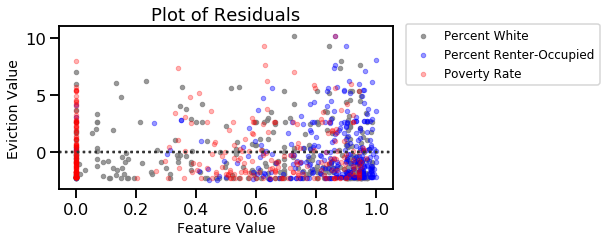

In [19]:
residual_plot(X,y)

In [20]:
residual_checks(X_train,y_train)

Tests of normality of residuals:
   - Jarque-Bera: 75.374
   - p-value: 0.0
   - Skew: 0.606
   - Kurtosis: 4.649


Tests of heteroskedasticty of residuals:
   - Lagrange multiplier statistic: 103.576
   - p-value: 0.0
   - f-value: 8.746
   - f p-value: 0.0


### Validation

In [31]:
y_hat_test = result.predict(X_test)

In [33]:
X_test_df = pd.DataFrame(X_test)
X_test_df.columns = ['constant']+X_labels
test_table = create_values_table(X_test_df, 'pct-white', y_test, y_hat_test)
test_table.head()

,pct-white,y,y_hat,residual
0,0.844973,2.70,2.122634,0.577366
1,0.877400,1.32,1.094787,0.225213
2,0.889159,0.34,1.119931,-0.779931
3,0.617179,4.74,2.807563,1.932437
4,0.826993,0.54,2.087350,-1.547350


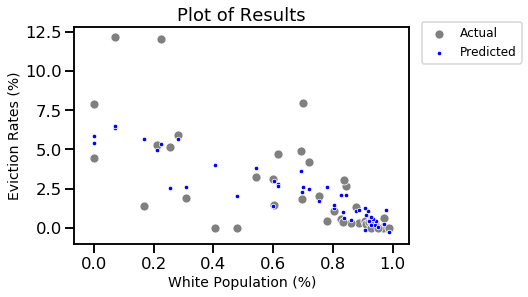

In [34]:
y_vs_y_hat_scatter(test_table['pct-white'], test_table['y'], test_table['y_hat']) 

In [35]:
print('Training MSE:', round(mean_squared_error(y_train, y_hat_train),2))
print('Test MSE:', round(mean_squared_error(y_test, y_hat_test),2))

Training MSE: 3.4
Test MSE: 5.27


### Cross-Validation

In [173]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

print('CV MSE with 5 folds:', -round(np.mean(cross_val_score(linreg, X_test, y_test, cv=5,  scoring='neg_mean_squared_error')),2))
print('CV MSE with 10 folds:', -round(np.mean(cross_val_score(linreg, X_test, y_test, cv=10, scoring='neg_mean_squared_error')),2))
print('CV MSE with 20 folds:', -round(np.mean(cross_val_score(linreg, X_test, y_test, cv=20, scoring='neg_mean_squared_error')),2))

CV MSE with 5 folds: 17.74
CV MSE with 10 folds: 15.46
CV MSE with 20 folds: 18.59


### Lasso

In [169]:
# Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, .5, 1]

# Initialize the dataframe to store coefficients
conduct_search(initialize_search(X_labels, alpha_lasso), X_train, y_train, alpha_lasso)

,MSE,intercept,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,pct-white,pct-hispanic,pct-am-ind,pct-asian,pct-nh-pi,pct-multiple,% Affordable Units
alpha_1e-15,3.4,0.691997,1.46154,1.6598,0.0881697,3.27448,-0.99998,0.902571,0.218892,0.4059,-4.86044,-0.852122,0.0680262,-0.143837,-0.154593,0.834603,-0.552096
alpha_1e-10,3.4,0.691997,1.46154,1.6598,0.0881697,3.27448,-0.99998,0.902571,0.218892,0.4059,-4.86044,-0.852122,0.0680262,-0.143837,-0.154593,0.834603,-0.552096
alpha_1e-08,3.4,0.691998,1.46154,1.6598,0.0881699,3.27448,-0.999979,0.90257,0.218892,0.4059,-4.86044,-0.852121,0.068026,-0.143837,-0.154589,0.834603,-0.552095
alpha_1e-05,3.4,0.69327,1.4606,1.65995,0.0883728,3.27355,-0.999079,0.902104,0.218771,0.405359,-4.86033,-0.851826,0.0679075,-0.143739,-0.149928,0.834357,-0.550982
alpha_0.0001,3.4,0.704695,1.45222,1.6613,0.0900126,3.26537,-0.990949,0.897919,0.217687,0.400471,-4.85934,-0.849174,0.0668368,-0.142839,-0.107953,0.832137,-0.54096
alpha_0.001,3.4,0.821542,1.38194,1.67284,0.0900104,3.19558,-0.907851,0.862174,0.193416,0.350468,-4.85323,-0.825118,0.0554072,-0.133392,-0,0.81281,-0.442004
alpha_0.01,3.44,1.91701,0.7471,1.7842,0.0375377,2.49836,-0.147802,0.485297,0,0,-4.81677,-0.605871,0,-0.0264831,-0,0.628876,-0
alpha_0.5,6.33,3.38374,0,0.296065,0,0,-0,-0,-0,0,-1.43612,-0,-0,-0,0,-0,0
alpha_1,8.37,2.63049,0,0,0,0,-0,-0,-0,0,-0,-0,-0,-0,0,-0,0


In [170]:
lasso = Lasso(alpha=0.001, max_iter=1e5)
lasso.fit(X_train, y_train)

y_h_lasso_train = lasso.predict(X_train)
y_h_lasso_test = lasso.predict(X_test)

print('Lasso Training MSE:', round(mean_squared_error(y_train, y_h_lasso_train),2))
print('Lasso Test MSE:', round(mean_squared_error(y_test, y_h_lasso_test),2))

Lasso Training MSE: 3.4
Lasso Test MSE: 5.26


<a id='findings'></a>
## Analysis and Findings

1. Eviction disproportionately impacts people of color
2. Percentage of renter occupied households and poverty-rate also have some predictive power for eviction rate
3. The count of PUDs and the provision of afforable housing have no clear impact on eviction rates 

<a id='recs'></a>
## Recommendations

1. Continue analysis at block group level, accounting for the fact that a PUD may be adjacent to one or more block groups
2. Repeat analysis, taking into account PUD status as of 2016 (year of eviction rate data)
3. Evaluate findings across time series data, including development timeline of PUD
4. Repeat analysis with other development vehicles, such as Tax Increment Financing
5. Synthesize findings with additional research about PUD community impact beyond count of affordable units, such as count of family-sized units, project value, etc.
